# Using neural nets to solve an optimal control problem: A simple example

#### by [Mahdi Ebrahimi Kahou](https://sites.google.com/site/mahdiebrahimikahou/)

Here I create an animation that shows the time evolution of the neural network during the optimization.

If you want a full description of the problem and algorithm see: [The other file](https://github.com/Mekahou/Fun-Stuff/edit/main/codes/linear%20quadratic%20DP%20DNN/3.%20LQ_DP_DNN_Training_Main.ipynb)

In [1]:
import quantecon as qe
import quantecon.lqcontrol as LQ
import numpy as np

import matplotlib.pyplot as plt


In [2]:
class Exact_sol:
    def __init__(self,
                 beta = 0.95,
                 alpha_0 = 1.0,
                 alpha_1 = 2.0,
                 gamma = 90.0,
                 h_0 =  0.03,
                 h_1 = 0.94,
                 time = 63,
                 y_0 = 0.1,
                 Y_0 = 0.2
                ):
        
        self.beta = beta
        self.alpha_0 = alpha_0
        self.alpha_1 = alpha_1
        self.gamma = gamma
        self.h_0 = h_0
        self.h_1= h_1
        self.time = time
        self.y_0 = y_0
        self.Y_0 = Y_0
        
        self.R = np.matrix([[0.0,-self.alpha_0/2 , 0.0],[-self.alpha_0/2, 0.0, self.alpha_1/2],[0.0,self.alpha_1/2, 0.0]])
        self.Q = self.gamma/2
        self.A = np.matrix([[1.0,0.0,0.0],[0.0,1.0,0.0],[self.h_0,0.0, self.h_1]])
        self.B = np.matrix([[0.0],[1.0],[0.0]])
        
        self.lq = LQ.LQ(self.Q, self.R, self.A, self.B, beta=self.beta)
        self.P, self.F, self.d = self.lq.stationary_values()
        
        self.x_0 = np.matrix([[1.0],[self.y_0],[self.Y_0]])
        self.dynamics = self.lq.compute_sequence(self.x_0,self.time)
        
        self.ones = self.dynamics[0][0].reshape([self.time+1,1])
        self.y_t = self.dynamics[0][1].reshape([self.time+1,1])
        self.Y_t = self.dynamics[0][2].reshape([self.time+1,1])
        
        self.x_t = np.concatenate((self.ones,self.y_t,self.Y_t), axis=1).T
        
        self.u_t = -np.dot(self.F,self.x_t).T
        

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        torch.manual_seed(1)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.ReLU())  
            
        module.append(nn.Linear(self.dim_hidden,1))
        
        self.u = nn.Sequential(*module)


    def forward(self, x):
        u_out = self.u(x)
        return  u_out

In [5]:
class Data:
    def __init__(self,
                 beta = 0.95,
                 alpha_0 = 1.0,
                 alpha_1 = 2.0,
                 gamma = 90.0,
                 h_0 =  0.03,
                 h_1 = 0.94,
                 time = 64,
                 Y_0 = 0.2,
                 batch_size = 4
                ):
        self.beta = beta
        self.alpha_0 = alpha_0
        self.alpha_1 = alpha_1
        self.gamma = gamma
        self.h_0 = h_0
        self.h_1= h_1
        self.time = time
        self.Y_0 = Y_0
        self.batch_size = batch_size
        
        self.Y_t = torch.zeros([self.time])
        self.Y_t[0] = self.Y_0
        for t in range(self.time-1):
            self.Y_t[t+1] = self.h_0 + self.h_1*self.Y_t[t]
            
        self.Y_prime_t = self.h_0 + self.h_1*self.Y_t
        
        self.train_data = torch.stack((self.Y_t,self.Y_prime_t),1)


In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
class Data_loader(Dataset):
    
    def __init__(self,data):
        self.data = data
        self.Y = self.data[:,[0]]
        self.Y_prime = self.data[:,1:]
        self.n_samples = self.data.shape[0]

    def __getitem__(self,index):
            return self.Y[index], self.Y_prime[index] # order: Y first, then Y_prime 
        
    def __len__(self):
        return self.n_samples

In [8]:
data_set = Data().train_data
data_label = Data_loader(data = data_set)
batch_size = Data().batch_size
train = DataLoader(dataset = data_label, batch_size = batch_size, shuffle = True)


In [9]:
α_0 = Data().alpha_0
α_1 = Data().alpha_1
γ = Data().gamma
β = Data().beta

In [10]:
max_epochs = 50

In [11]:
u_hat = NN()
learning_rate = 1e-2

optimizer = torch.optim.Adam(u_hat.parameters(), lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 20, threshold = 0.0 , cooldown =  1 )

In [12]:
u_hat.eval()
Y_t = Data().train_data[:,[0]]

approx_sol = u_hat(Y_t).detach()

exact_sol = Exact_sol().u_t

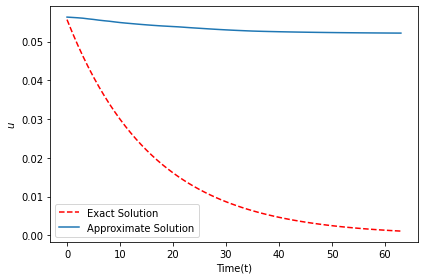

In [13]:
plt.plot(exact_sol, "--", color='r', label= r"Exact Solution")
plt.plot(approx_sol,label= r"Approximate Solution" )
plt.ylabel(r"$u$")
plt.xlabel(r"Time(t)")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [14]:
result = torch.zeros([Data().time,200]) #The evolution of the neural net during the optimization will be saved here
i = 0
Y_t = Data().train_data[:,[0]]

In [15]:
for epoch in range(max_epochs):
    for index, (Y,Y_prime) in enumerate(train):
        
        euler_res = γ*u_hat(Y) - β*( γ*u_hat(Y_prime) + α_0 - α_1* Y_prime )
        loss = euler_res.pow(2).mean()
        if index % 5 == 0:
            result[:,i] = u_hat(Y_t).detach().squeeze()
            i = i+1
             
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    scheduler.step()
    #if epoch % 1 == 0:
    #    print("epoch:",epoch, ",","MSE Euler Residuals:","{:.2e}".format(loss.item()))    

        

In [16]:
u_hat.eval()
Y_t = Data().train_data[:,[0]]

approx_sol = u_hat(Y_t).detach()

exact_sol = Exact_sol().u_t

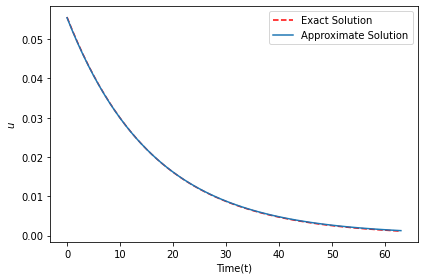

In [17]:
plt.plot(exact_sol, "--", color='r', label= r"Exact Solution")
plt.plot(approx_sol,label= r"Approximate Solution" )
plt.ylabel(r"$u$")
plt.xlabel(r"Time(t)")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

### Creating the animation

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [19]:
fontsize= 16
ticksize = 14
figsize = (6, 3.5)
params = {"text.usetex": True,
    'font.family':'serif',
    "figure.figsize":figsize, 
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize, 
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}

plt.rcParams.update(params)   

In [20]:
filenames = []
for i in range(result.shape[1]):
    # plot the line chart
    plt.rcParams.update(params)   
    plt.plot(result[:,i],label= r"Approximate Solution" )
    plt.plot(Exact_sol().u_t,"--",color='r', label = r"Exact Solution")
    plt.ylabel(r"$u(t)$")
    plt.xlabel(r"Time(t)")
    plt.legend(loc='upper right')
    plt.ylim(0.0,0.06)
    plt.xlim(0,64)
    plt.tight_layout()
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
with imageio.get_writer('u_hat.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)